## Kernel to load: vax_inc_geo

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from textwrap import wrap
import rasterio 
import rasterio.plot
import matplotlib
import jenkspy
import random
import matplotlib.patches as mpatches
import os
import warnings
warnings.simplefilter("ignore", UserWarning)
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

Cannot find header.dxf (GDAL_DATA is not defined)


# Must run 'Generate Arcpy datafiles for disease-specific vaccination plotting.ipynb' before this code

In [2]:
notebook_dir = os.path.dirname(os.getcwd())
source_data_path=os.path.join(notebook_dir, "Common Source Data")

In [3]:
all_files=[]
for path, subdirs, files in os.walk('ARCPY Maps/'):
    for name in files:
        all_files+=[path+
                    '/'+name.replace('\\\\','/')]
        
files_vaccinated=[i for i in all_files if 'scaled_vaccinated_plus1_log10.tif' in i if i[-4:]=='.tif']
files_unvaccinated=[i for i in all_files if 'scaled_unvaccinated_plus1_log10.tif' in i if i[-4:]=='.tif']
files_prohibited=[i for i in all_files if 'vaccination_prohibited.shp' in i if i[-4:]=='.shp']


In [4]:
vaccinated_animal_disease_dict=dict()
for file in files_vaccinated:
    animal=file.split('/')[1].split('\\')[0]
    disease=file.split('/')[1].split('\\')[1].replace('_area_adjusted','')
    vaccinated_animal_disease_dict[(animal,disease)]=file
    
unvaccinated_animal_disease_dict=dict()
for file in files_unvaccinated:
    animal=file.split('/')[1].split('\\')[0]
    disease=file.split('/')[1].split('\\')[1].replace('_area_adjusted','')
    unvaccinated_animal_disease_dict[(animal,disease)]=file

prohibited_animal_disease_dict=dict()
for file in files_prohibited:
    animal=file.split('/')[1].split('\\')[0]
    disease=file.split('/')[1].split('\\')[1].replace('_area_adjusted','')
    prohibited_animal_disease_dict[(animal,disease)]=file

In [5]:
# Read the shapefile
SHAPEFILE = os.path.join(source_data_path,'ne_10m_admin_0_countries','ne_10m_admin_0_countries.shp')
geo_df = gpd.read_file(SHAPEFILE)[['ADMIN', 'ADM0_A3', 'geometry']]

# Rename columns
geo_df.columns = ['country', 'country_code', 'geometry']
geo_df = geo_df.drop(geo_df.loc[geo_df['country'] == 'Antarctica'].index)
geo_df.reset_index(drop=True, inplace=True)

### Prop Unvaccinated rasters (yellow, red)

0.0 3.5609064
Cattle Anthrax


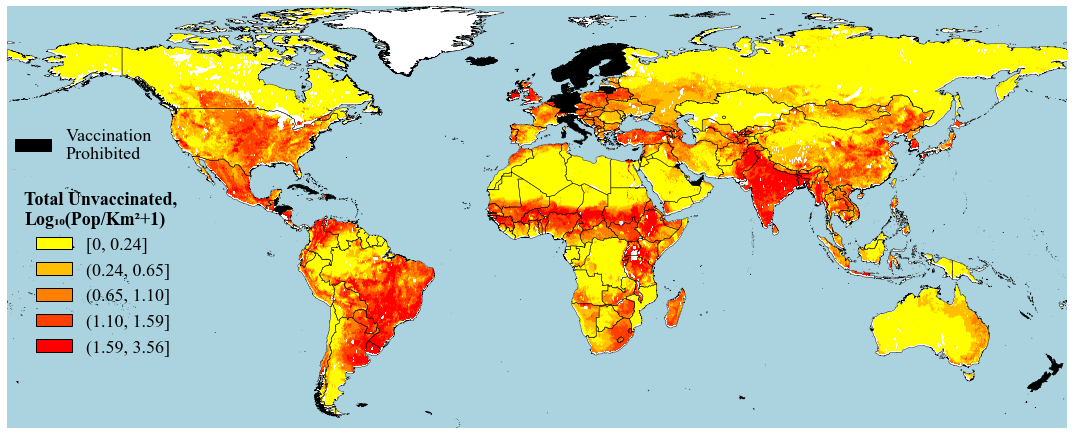

0.0 3.2653008
Cattle Brucella Abortus


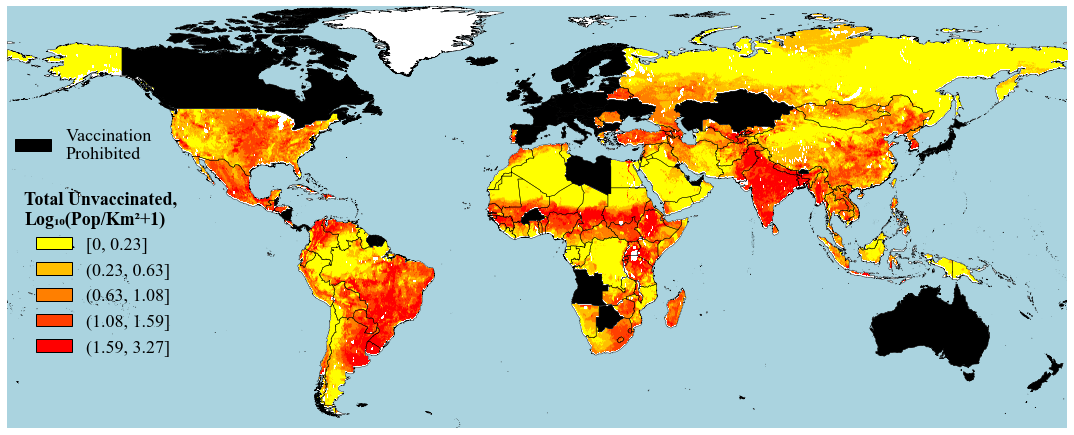

0.0 3.2570431


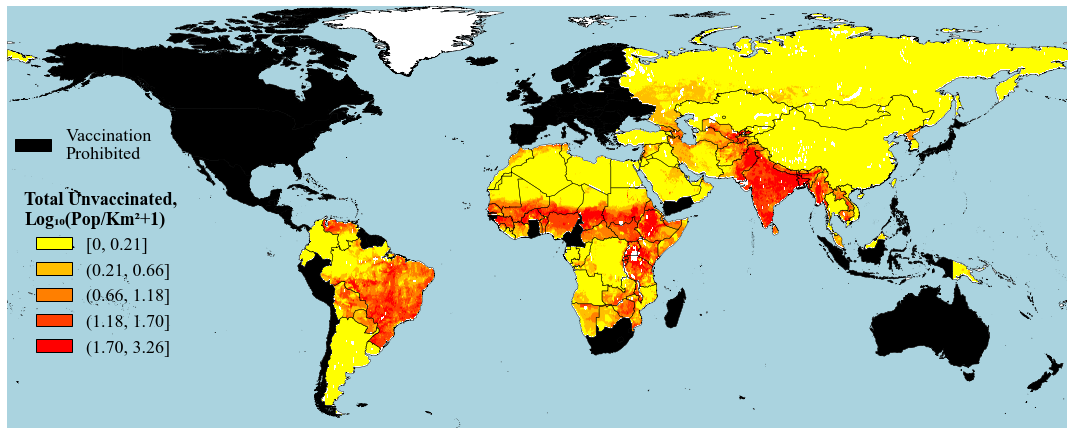

0.0 3.1572022
Cattle Lumpy Skin Disease


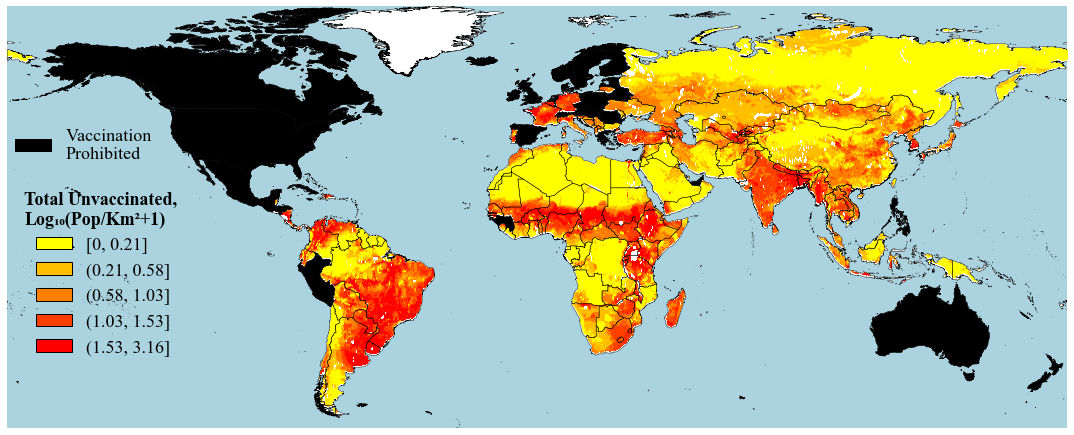

0.0 3.4208436
Cattle Rabies


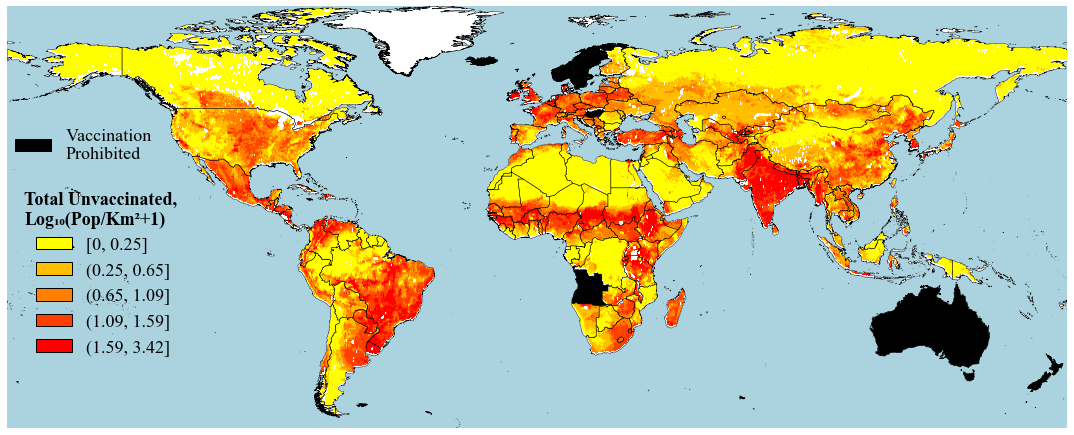

0.0 3.5303626
Pigs Anthrax


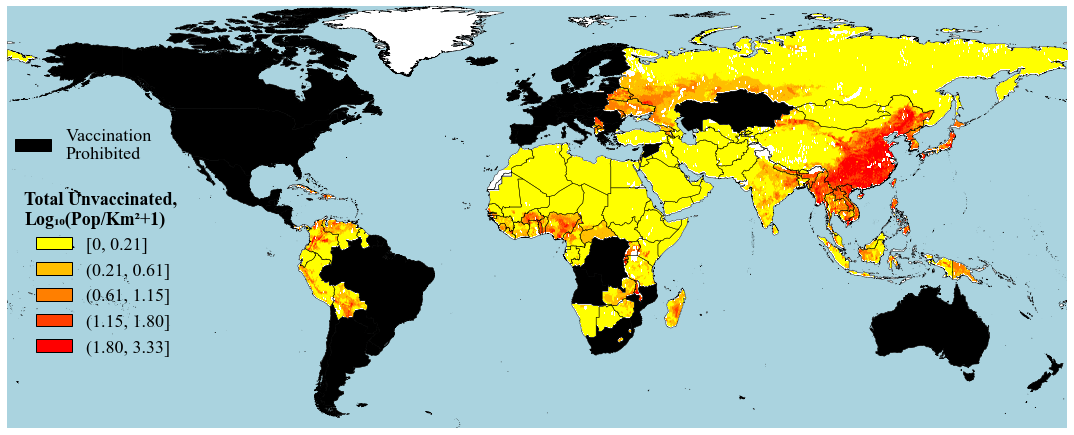

0.0 3.5485168
Pigs Rabies


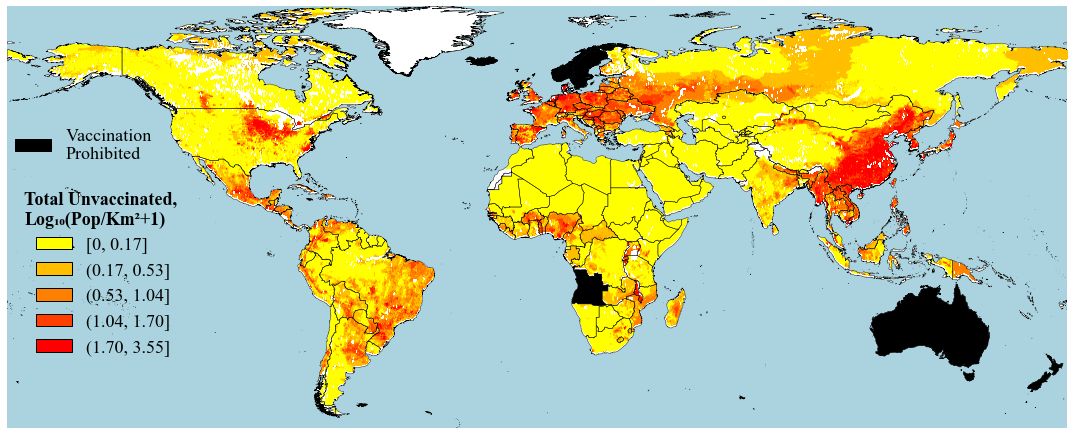

0.0 5.100146
Poultry Avian Infectious Bronchitis


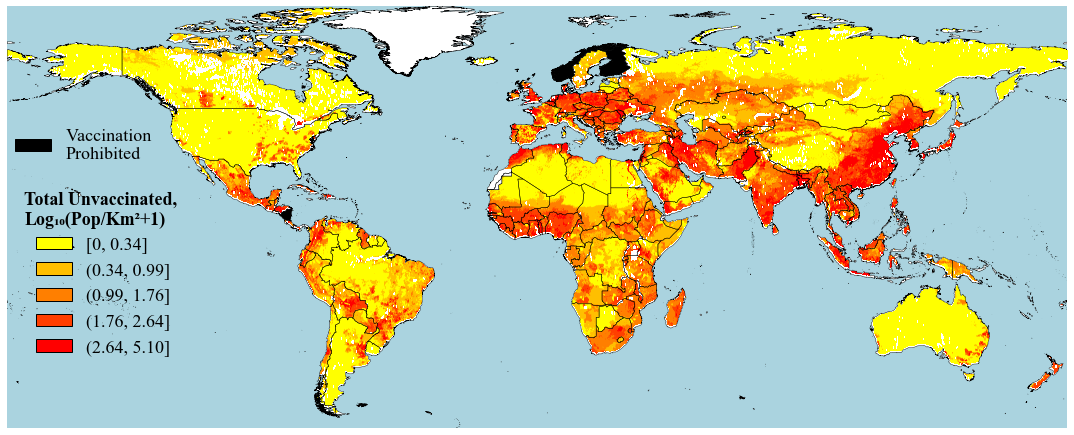

0.0 5.1130958
Poultry Avian Infectious Laryngotracheitis


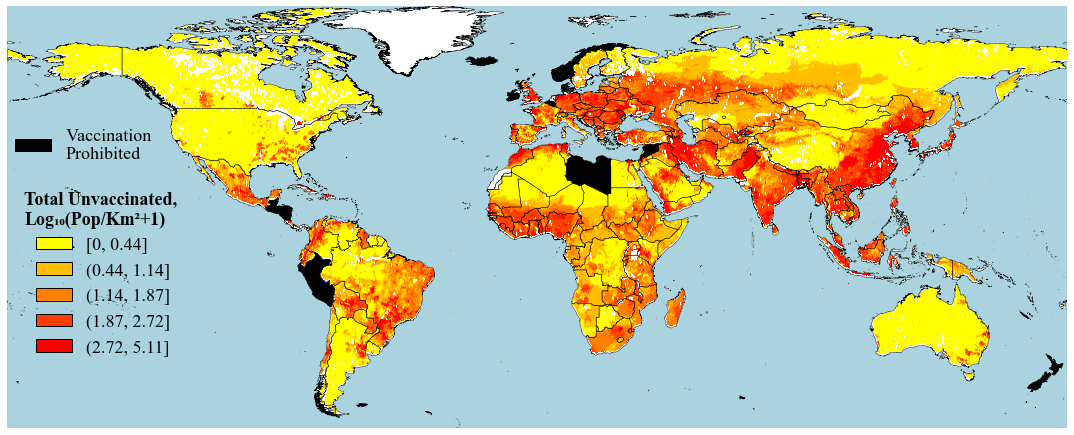

0.0 5.115904
Poultry Infectious Bursal Disease (Gumboro Disease)


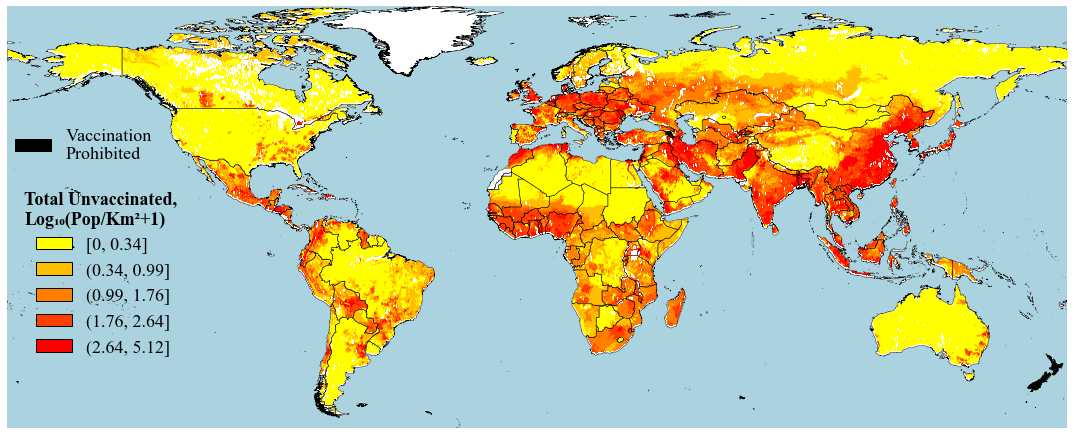

0.0 5.115904
Poultry Marek's Disease


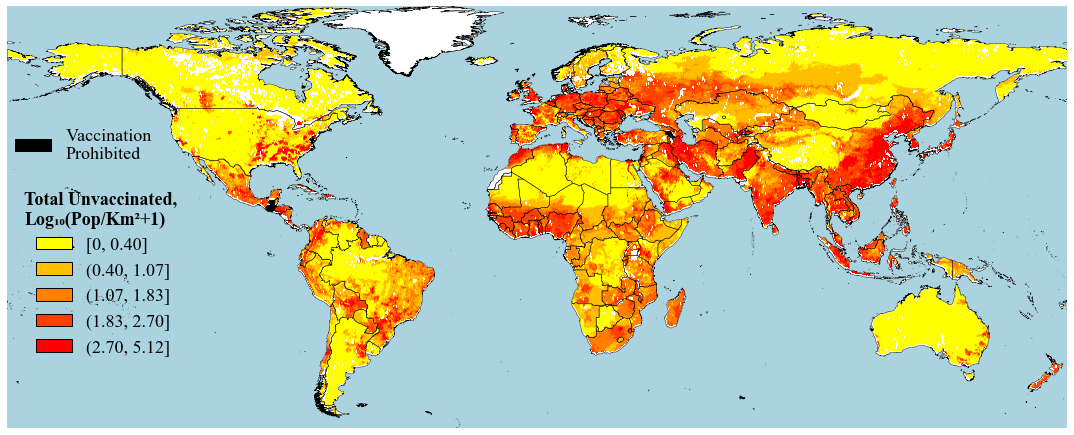

0.0 5.1133523
Poultry Newcastle Disease


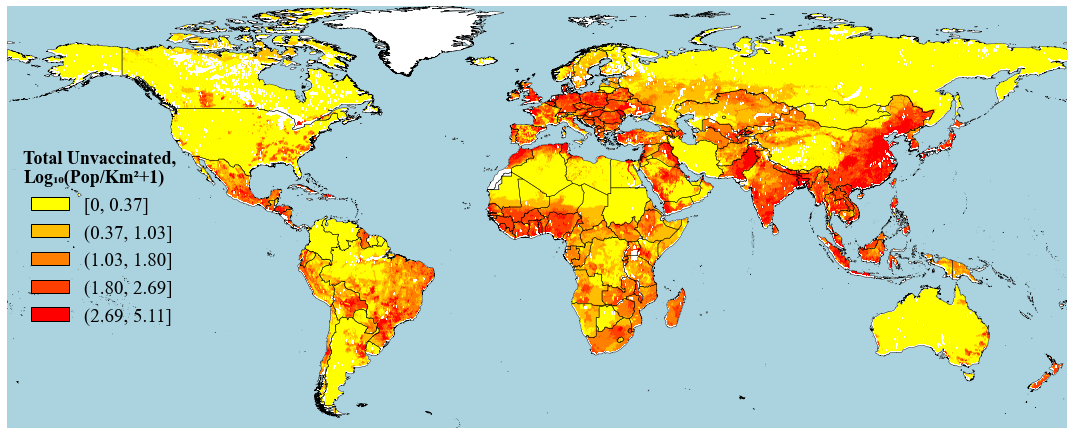

In [6]:
for animal_disease_pair in list(unvaccinated_animal_disease_dict.keys()):
    if animal_disease_pair in prohibited_animal_disease_dict.keys():
        prohibited_df=gpd.read_file(prohibited_animal_disease_dict[animal_disease_pair])
    else:
        prohibited_df=None
    
    animal=animal_disease_pair[0]
    disease=animal_disease_pair[1]
    
#     if "castle" not in disease:
#         continue

    # Read the raster file
    raster_path = unvaccinated_animal_disease_dict[animal_disease_pair]    
    
    raster = rasterio.open(raster_path)
    highest_resolution = raster.res[0]
    
    # Read the raster data at the highest resolution
    raster_data = raster.read(1, out_shape=(1, int(raster.height // highest_resolution), int(raster.width // highest_resolution)))
    
    #raster_data = raster.read(1)  # Change the band number if required
    
    # Get the extent of the raster image
    left, bottom, right, top = raster.bounds
    
    cmap_custom=matplotlib.colors.LinearSegmentedColormap.from_list("", ["yellow","red"])
    
    raster_data = np.where(raster_data == raster_data[0][0], np.nan, raster_data)
    vmax_ultimate=np.nanmax(raster_data)
    vmin_ultimate=np.nanmin(raster_data)
    
    print(vmin_ultimate,vmax_ultimate)
    
    raster_flat = raster_data.flatten()
    jenks_vals = raster_flat[~np.isnan(raster_flat)].tolist()
    # Optimized sampling
    jenks_vals = raster_data.ravel()[~np.isnan(raster_data.ravel())]
    if len(jenks_vals) > 100000:
        jenks_vals = np.random.choice(jenks_vals, size=100000, replace=False)
    jenks_vals = jenks_vals.tolist()
    #if vmax_ultimate not in jenks_vals:
    #    jenks_vals+=[vmax_ultimate]
    #if vmin_ultimate not in jenks_vals:
    #    jenks_vals+=[vmin_ultimate]
    
    categories=jenkspy.jenks_breaks(jenks_vals,5)
    
    
    raster_data = np.where((raster_data >=categories[0]) & (raster_data<= categories[1]),0, raster_data)
    raster_data = np.where((raster_data >categories[1]) & (raster_data<= categories[2]),0.25, raster_data)
    raster_data = np.where((raster_data >categories[2]) & (raster_data<= categories[3]),0.5, raster_data)
    raster_data = np.where((raster_data >categories[3]) & (raster_data<= categories[4]),0.75, raster_data)
    raster_data = np.where((raster_data >categories[4]),1, raster_data)
    
    
    plt.rcParams["font.family"] = "Times New Roman"

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(19,17.5))
    cmap_custom = matplotlib.colors.LinearSegmentedColormap.from_list("", ["yellow", "red"])
    # Plot the raster image
    
    ax.set_facecolor((170 / 255, 211 / 255, 223 / 255))
    
    geo_df.plot(facecolor='white', edgecolor='none', ax=ax, zorder=1)
    
    vmin = np.nanmin(raster_data)
    vmax = np.nanmax(raster_data)
    im = ax.imshow(raster_data, cmap=cmap_custom, vmin=vmin, vmax=vmax, extent=(left, right, bottom, top), zorder=2)
    
    # Plot the shapefile with reduced edge width
    geo_df.plot(facecolor='none', edgecolor='black', linewidth=0.4, ax=ax, zorder=3)
    
    try:
        prohibited_df.plot(facecolor='black', edgecolor='black', linewidth=0.2, ax=ax, zorder=4)
        prohibited_plotted=True
    except:
        prohibited_plotted=False
        
    
    # Set the aspect ratio to equal
    ax.set_aspect('equal')
    
    # Remove spines
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Remove xticks and yticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    patch1 = mpatches.Patch(edgecolor='black', facecolor=cmap_custom(0), label='[0, '+'{:.2f}'.format(round(categories[1], 2))+']')
    patch2 = mpatches.Patch(edgecolor='black', facecolor=cmap_custom(0.25), label='('+'{:.2f}'.format(round(categories[1], 2))+', '+'{:.2f}'.format(round(categories[2], 2))+']')
    patch3 = mpatches.Patch(edgecolor='black', facecolor=cmap_custom(0.5), label='('+'{:.2f}'.format(round(categories[2], 2))+', '+'{:.2f}'.format(round(categories[3], 2))+']')
    patch4 = mpatches.Patch(edgecolor='black', facecolor=cmap_custom(0.75), label='('+'{:.2f}'.format(round(categories[3], 2))+', '+'{:.2f}'.format(round(categories[4], 2))+']')
    patch5 = mpatches.Patch(edgecolor='black', facecolor=cmap_custom(.999), label='('+'{:.2f}'.format(round(categories[4], 2))+', '+'{:.2f}'.format(round(vmax_ultimate, 2))+']')
    
    patchNone = mpatches.Patch(edgecolor='black', facecolor='black', label='Vaccination \nProhibited')
    
        
    if prohibited_plotted:
        legend2 = plt.legend(bbox_to_anchor=(0.155, 0.75), loc=1,
                        handles=[patchNone],fontsize=18,
                        frameon=False)
        
    
    
    
    if prohibited_plotted:
        
        legend = ax.legend(bbox_to_anchor=(0.18, 0.6), loc=1,
                        handles=[patch1, patch2, patch3, patch4, patch5],fontsize=18,
                        frameon=False)
    
        legend.set_title('Total Unvaccinated, \nLog₁₀(Pop/Km²+1)',prop={'size':18})
        
        plt.gca().add_artist(legend2)
        
    else:
        legend = plt.legend(bbox_to_anchor=(0.18, 0.7), loc=1,
                    handles=[patch1, patch2, patch3, patch4, patch5],fontsize=19,
                    frameon=False)
        legend.set_title('Total Unvaccinated, \nLog₁₀(Pop/Km²+1)',prop={'size':18})

    
    # Set the legend title font weight
    title = legend.get_title()
    title.set_fontweight('bold')
    
    ## Set font weight for all legend labels in ax1
    #for text in legend.get_texts():
    #    #text.set_fontweight('bold')
    #    ...
    #
    ## Set font weight for all legend labels in ax2
    #for text in legend2.get_texts():
    #    #text.set_fontweight('bold')
    #    ...
    #
    ax.set_xlim(geo_df.total_bounds[0], geo_df.total_bounds[2])
    ax.set_ylim(geo_df.total_bounds[1], geo_df.total_bounds[3])
    
    print(animal,disease)
    
    os.makedirs("Unvaccinated maps", exist_ok=True)
    os.makedirs("Unvaccinated maps/yellow_red", exist_ok=True)


    plt.savefig('Unvaccinated maps/yellow_red/'+animal+'_'+disease+'unvaccination coverage high res.svg', format='svg',
            bbox_inches='tight', pad_inches=0,dpi=600)
    plt.savefig('Unvaccinated maps/yellow_red/'+animal+'_'+disease+'unvaccination coverage high res.png', format='png',
            bbox_inches='tight', pad_inches=0,dpi=600)
    
    
    plt.show()